# import the libraries

In [2]:
import numpy as np 
import pandas as pd 
import os 
import re 
import nltk 
nltk.download('stopwords') 
nltk.download('punkt') 
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words('english')) 
import matplotlib.pyplot as plt 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AJAY\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading Data

In [3]:
input_data = pd.read_csv('Tweets.csv')
input_data = input_data[['label','tweet']]

In [4]:
input_data.head()

,label,tweet
0,positive,@VirginAmerica nervous about my flight from DC...
1,positive,@VirginAmerica cool picture of another VirginA...
2,positive,@VirginAmerica Keep up the great work :)
3,positive,@VirginAmerica my goodness your people @love f...
4,positive,@VirginAmerica Thanks for a great flight from ...


In [5]:
input_data.shape

(14438, 2)

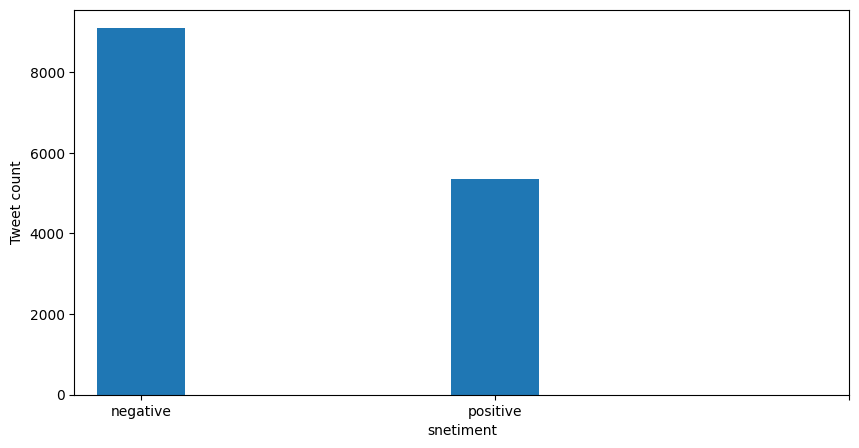

In [6]:
label_dist = input_data['label'].value_counts().to_dict()
flg = plt.figure(figsize = (10,5))
ax = plt.bar(label_dist.keys(), label_dist.values(), width=0.25) 
plt.xticks([0,1,2]) 
plt.xlabel('snetiment') 
plt.ylabel('Tweet count') 
plt.show()

In [7]:
#check for any dupicates tweets 

len(input_data['tweet'])-len(input_data['tweet'].drop_duplicates()) 

212

In [8]:
input_data = input_data.drop_duplicates(subset='tweet', keep='last')
input_data.shape

(14226, 2)

In [12]:
input_data['length'] = input_data['tweet'].apply(lambda x: len(x.split(' '))) 

In [13]:
input_data.sample(10)

,label,tweet,length
5629,positive,@SouthwestAir can you please DM me? I have a q...,13
6859,positive,@JetBlue when I check in tomorrow morning for ...,19
8575,negative,@JetBlue even @Citi responded quicker via Twit...,21
4144,negative,@SouthwestAir Logically you would think you ch...,24
12233,negative,@AmericanAir especially during a death in the ...,16
2516,negative,@united &amp; on top of no free tv on the int’...,30
2116,negative,@united sloppy stuff you don't see anymore - u...,18
13323,positive,@AmericanAir Karen Riedel is a rock star emplo...,20
3988,positive,"@united Hi again, any updates here?",6
6821,positive,😂😂 RT @JetBlue: Our fleet's on fleek. http://t...,8


In [15]:
#cal avg length of the positive and nagative tweet 

print(round(input_data[input_data['label']=='negative']['length'].mean()))
print(round(input_data[input_data['label']=='positive']['length'].mean()))

20
14


<Axes: ylabel='Frequency'>

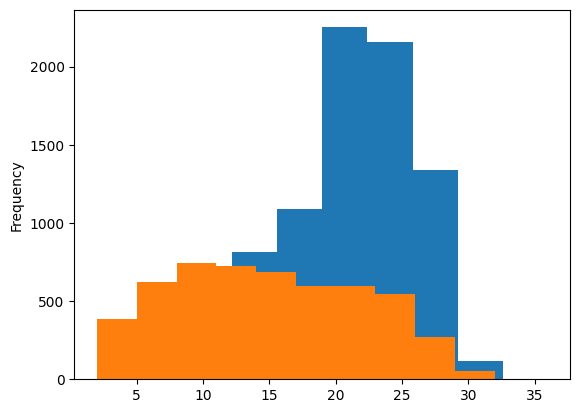

In [18]:
# plot the distrubution based on the length of the twwets for each label 

input_data[input_data['label']=='negative']['length'].plot.hist(bins=10)
input_data[input_data['label']=='positive']['length'].plot.hist(bins=10)


In [19]:
input_data['tweet_new'] = input_data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)])) 

In [20]:
def text_clean(tweet):
    #lowercase the tweet
    tweet=tweet.lower()
    #remove punctuation 
    tweet = re.sub('[()!?]', ' ', tweet)
    tweet = re.sub('\[.*?\]',' ', tweet)
    #remove non alphanumeric occurences
    tweet = re.sub("[^a-z0-9]"," ", tweet)
    #remove the @mention
    tweet = re.sub("@[A-Za-z0-9_]+","", tweet)
    #remove the hastags
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet)
    #remove any links 
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www.\S+", "", tweet)
    return tweet

In [21]:
#apply the function on the tweet column 

input_data['clean_tweet'] = input_data['tweet_new'].apply(text_clean) 

In [23]:
input_data[['tweet', 'clean_tweet']].sample(10)

,tweet,clean_tweet
10565,Is it insulting that @USAirways @AmericanAir o...,is insulting usairways americanair offer no...
3728,@united Stop pretending you care about the wel...,united stop pretending care welfare daughter ...
12557,@AmericanAir 3611 was supposed to depart at 5:...,americanair 3611 supposed depart 5 10pm centr...
1486,@united I'd rather spend two days in the back ...,united i d rather spend two days back seat vo...
198,.@VirginAmerica If only you guys were starting...,virginamerica if guys starting flights end m...
916,@united there are a lot of unhappy cold people...,united lot unhappy cold people bridge freezin...
9599,@USAirways @AmericanAir Thank you for a couple...,usairways americanair thank couple easy has...
6196,@SouthwestAir I did ....it's just been such a ...,southwestair i it s disheartening experie...
10862,@USAirways @AmericanAir Total lack of cust. se...,usairways americanair total lack cust servi...
12064,@AmericanAir fly my child,americanair fly child


In [24]:
#calulated h updated length after removing the stopwords and cleaning tweets 
input_data['new_length'] = input_data['clean_tweet'].apply(lambda x:len(x.split(" ")))

In [25]:
#avg length of the tweet for positive and negtive labels 

print(round(input_data[input_data['label'] == 'negative']['new_length'].mean())) 
print(round(input_data[input_data['label'] == 'positive']['new_length'].mean()))

18
15


<Axes: ylabel='Frequency'>

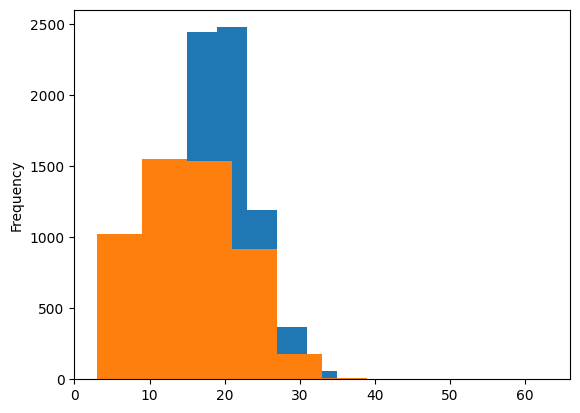

In [27]:
#plot the distribution for negative and postive labe tweets 
input_data[input_data['label']=='negative']['new_length'].plot.hist(bins=10)
input_data[input_data['label']=='positive']['new_length'].plot.hist(bins=10)


In [28]:
#frequency count
top_words = 20
#tokenize the tweets into individual tokens
words = nltk.tokenize.word_tokenize(input_data['clean_tweet'].str.cat(sep=' '))
#list of redundant words to be not considered in the frequency count
dropwords=['to','i','the','a','you','for','on','and','t','is','in','it','of','me','my','that','can','have','not','s',
          'co','http','are','was','with','at','your','this','we','be','2','get','from','an','do','so','up','m']
filter_words = [word for word in words if word not in dropwords]

In [29]:
#Use the FreqDist function from nltk for freq count
word_freq = nltk.FreqDist(filter_words)
#create the dataframe for top occuring words
wordfreq_df = pd.DataFrame(word_freq.most_common(top_words),
                    columns=['Word', 'Frequency'])

In [30]:
#print the dataframe
print(wordfreq_df)

            Word  Frequency
0         united       4146
1         flight       3829
2      usairways       3038
3    americanair       2798
4   southwestair       2447
5        jetblue       2382
6         thanks       1035
7      cancelled       1031
8        service        948
9           help        856
10          time        773
11      customer        741
12           amp        667
13         hours        664
14            us        662
15          hold        636
16         plane        630
17       flights        630
18         still        576
19         thank        571


# Data Split

In [31]:
#Sentiment Classifier
#split the data into training and test set with balanced split based on target class
X_train, X_test, y_train, y_test = train_test_split(input_data["clean_tweet"],
                                                    input_data["label"],test_size=0.3,
                                                    stratify=input_data['label'])

In [33]:
print(X_train.shape[0],X_test.shape[0])

9958 4268


In [34]:
print(y_train.value_counts())

label
negative    6301
positive    3657
Name: count, dtype: int64


In [35]:
#check the target class balance in test data 
print(y_test.value_counts())

label
negative    2701
positive    1567
Name: count, dtype: int64


# ML Modeling and Performance Evalution

In [36]:
# Use the countvectoriser to convert text data into numerical/vector form
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [37]:
# train using Logistic Regression Model 
lr = LogisticRegression()
lr.fit(X_train_vec,y_train)
print(confusion_matrix(lr.predict(X_test_vec),y_test))
print(classification_report(lr.predict(X_test_vec),y_test))

[[2360  372]
 [ 341 1195]]
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      2732
    positive       0.76      0.78      0.77      1536

    accuracy                           0.83      4268
   macro avg       0.82      0.82      0.82      4268
weighted avg       0.83      0.83      0.83      4268



In [38]:
#train and evaluate the multinominal Naive Baysian Classifier model 
MNB = MultinomialNB()
MNB.fit(X_train_vec,y_train)
print(confusion_matrix(MNB.predict(X_test_vec),y_test))
print(classification_report(MNB.predict(X_test_vec),y_test))

[[2496  572]
 [ 205  995]]
              precision    recall  f1-score   support

    negative       0.92      0.81      0.87      3068
    positive       0.63      0.83      0.72      1200

    accuracy                           0.82      4268
   macro avg       0.78      0.82      0.79      4268
weighted avg       0.84      0.82      0.82      4268



In [39]:
#train and evaluate the RF classifier model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec,y_train)
print(confusion_matrix(rf.predict(X_test_vec),y_test))
print(classification_report(rf.predict(X_test_vec),y_test))

[[2378  468]
 [ 323 1099]]
              precision    recall  f1-score   support

    negative       0.88      0.84      0.86      2846
    positive       0.70      0.77      0.74      1422

    accuracy                           0.81      4268
   macro avg       0.79      0.80      0.80      4268
weighted avg       0.82      0.81      0.82      4268



In [40]:
# Use TF-IDF and train logistic regression
vectorizertfidf = TfidfVectorizer(use_idf=True)
X_train_tfvec = vectorizertfidf.fit_transform(X_train)
X_test_tfvec = vectorizertfidf.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_tfvec,y_train)
#evaluate the performance of logistic model on test data 
print(confusion_matrix(lr.predict(X_test_tfvec),y_test))
print(classification_report(lr.predict(X_test_tfvec),y_test))

[[2469  493]
 [ 232 1074]]
              precision    recall  f1-score   support

    negative       0.91      0.83      0.87      2962
    positive       0.69      0.82      0.75      1306

    accuracy                           0.83      4268
   macro avg       0.80      0.83      0.81      4268
weighted avg       0.84      0.83      0.83      4268



In [41]:
#train and evaluate the RF classifier model
rf = RandomForestClassifier(n_estimators=200, random_state=0)
rf.fit(X_train_tfvec,y_train)
print(confusion_matrix(rf.predict(X_test_tfvec),y_test))
print(classification_report(rf.predict(X_test_tfvec),y_test))

[[2461  548]
 [ 240 1019]]
              precision    recall  f1-score   support

    negative       0.91      0.82      0.86      3009
    positive       0.65      0.81      0.72      1259

    accuracy                           0.82      4268
   macro avg       0.78      0.81      0.79      4268
weighted avg       0.83      0.82      0.82      4268



In [42]:
#train and evaluate the multinominal Naive Baysian Classifier model 
MNB =  MultinomialNB()
MNB.fit(X_train_tfvec,y_train)
print(confusion_matrix(MNB.predict(X_test_tfvec),y_test))
print(classification_report(MNB.predict(X_test_tfvec),y_test))

[[2656  925]
 [  45  642]]
              precision    recall  f1-score   support

    negative       0.98      0.74      0.85      3581
    positive       0.41      0.93      0.57       687

    accuracy                           0.77      4268
   macro avg       0.70      0.84      0.71      4268
weighted avg       0.89      0.77      0.80      4268



In [43]:
#train and evaluate the Linear Support Vector Classifier model 
SVC = LinearSVC()
SVC.fit(X_train_tfvec,y_train)
print(confusion_matrix(SVC.predict(X_test_tfvec),y_test))
print(classification_report(SVC.predict(X_test_tfvec),y_test))

C:\Users\AJAY\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[[2378  400]
 [ 323 1167]]
              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      2778
    positive       0.74      0.78      0.76      1490

    accuracy                           0.83      4268
   macro avg       0.81      0.82      0.82      4268
weighted avg       0.83      0.83      0.83      4268



# Performance on Test Data

In [44]:
test_df=pd.read_csv('test_tweets.csv')

In [45]:
test_df.shape

(202, 2)

In [48]:
test_df.head()

,label,tweet
0,positive,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,positive,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [49]:
#remove the stopwords from the test data 
test_df["tweet"]=test_df["tweet"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [50]:
# apply the helper function to clean the test data
test_df['tweet'] = test_df['tweet'].apply(text_clean)

In [51]:
#convert the test tweet data into tfidf vector using pre-trained vectorisor
test_vec = vectorizertfidf.transform(test_df['tweet'])

In [52]:
#make the predictions on the test data using trained logistic regression model 
predictions=lr.predict(test_vec)

In [53]:
#check for the performance of the model on test data 
print(confusion_matrix(predictions,test_df['label']))
print(classification_report(predictions,test_df['label']))

[[ 65  12]
 [ 19 106]]
              precision    recall  f1-score   support

    negative       0.77      0.84      0.81        77
    positive       0.90      0.85      0.87       125

    accuracy                           0.85       202
   macro avg       0.84      0.85      0.84       202
weighted avg       0.85      0.85      0.85       202



In [54]:
#add the model predictions to the test data 
test_df['predictions']=predictions
#validate the final test dataframe 
test_df.head()

,label,tweet,predictions
0,positive,virginamerica what dhepburn said,positive
1,positive,virginamerica plus added commercials experien...,positive
2,positive,virginamerica i today must mean i need tak...,positive
3,negative,virginamerica really aggressive blast obnoxio...,negative
4,negative,virginamerica really big bad thing,positive


In [55]:
#export the final submission file consisting model prediction on test data 
test_df.to_csv('final_prediction.csv')